In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from utils.analysis_helpers import build_network_from_interviews , plot_topic_transition_network

# Network (Single Topic/Doc) *Automatic* approach
Allow to have an overview of topics and their interactions.

**Pros:**
- Easy to see main themes across experiments.
- Straightforward network view of topic interactions.

**Cons:**
- Risk of false positives/negatives (due to the fact of forcing each docs (turn) into only one topic) 

In [3]:
df = pd.read_csv('./outputs/topics/df_topic_OBE.csv')

# Palette for the topics
unique_topics = df['one_topic'].unique()
cmap = plt.get_cmap('tab20', len(unique_topics))
palette = {topic: mcolors.to_hex(cmap(i)) for i, topic in enumerate(sorted(unique_topics))}

In [4]:
df.head(2)

,File Name,turn_index,Content,preprocessed_content,Experiment,Condition,Id,Speaker,one_topic,one_topic_name,multiple_topics,multiple_topics_name
0,ID 05,1,"so, that was very, let's say, unexpected and s...",let unexpected surprising moment go realize ge...,OBE1,1,5,Participant,0,0_body_myself_touch_focus,[0],['0_body_myself_touch_focus']
1,ID 05,3,"a little bit it was a little bit like, okay, w...",watch outside special give lot emotion explain...,OBE1,1,5,Participant,0,0_body_myself_touch_focus,[0],['0_body_myself_touch_focus']


**Topic Network of the Entire Experiment**

In addition to analyzing the topic network for the entire experiment, we can also explore topic networks within individual interviews. This would allow us to observe how exchanges evolve and how topics influence one another over time.

Furthermore, instead of focusing solely on the overall topic network for the entire experiment, we can examine the networks separately for each condition—Control and Intervention. This approach provides valuable insights into how conversational dynamics and topic interactions differ between the two conditions.

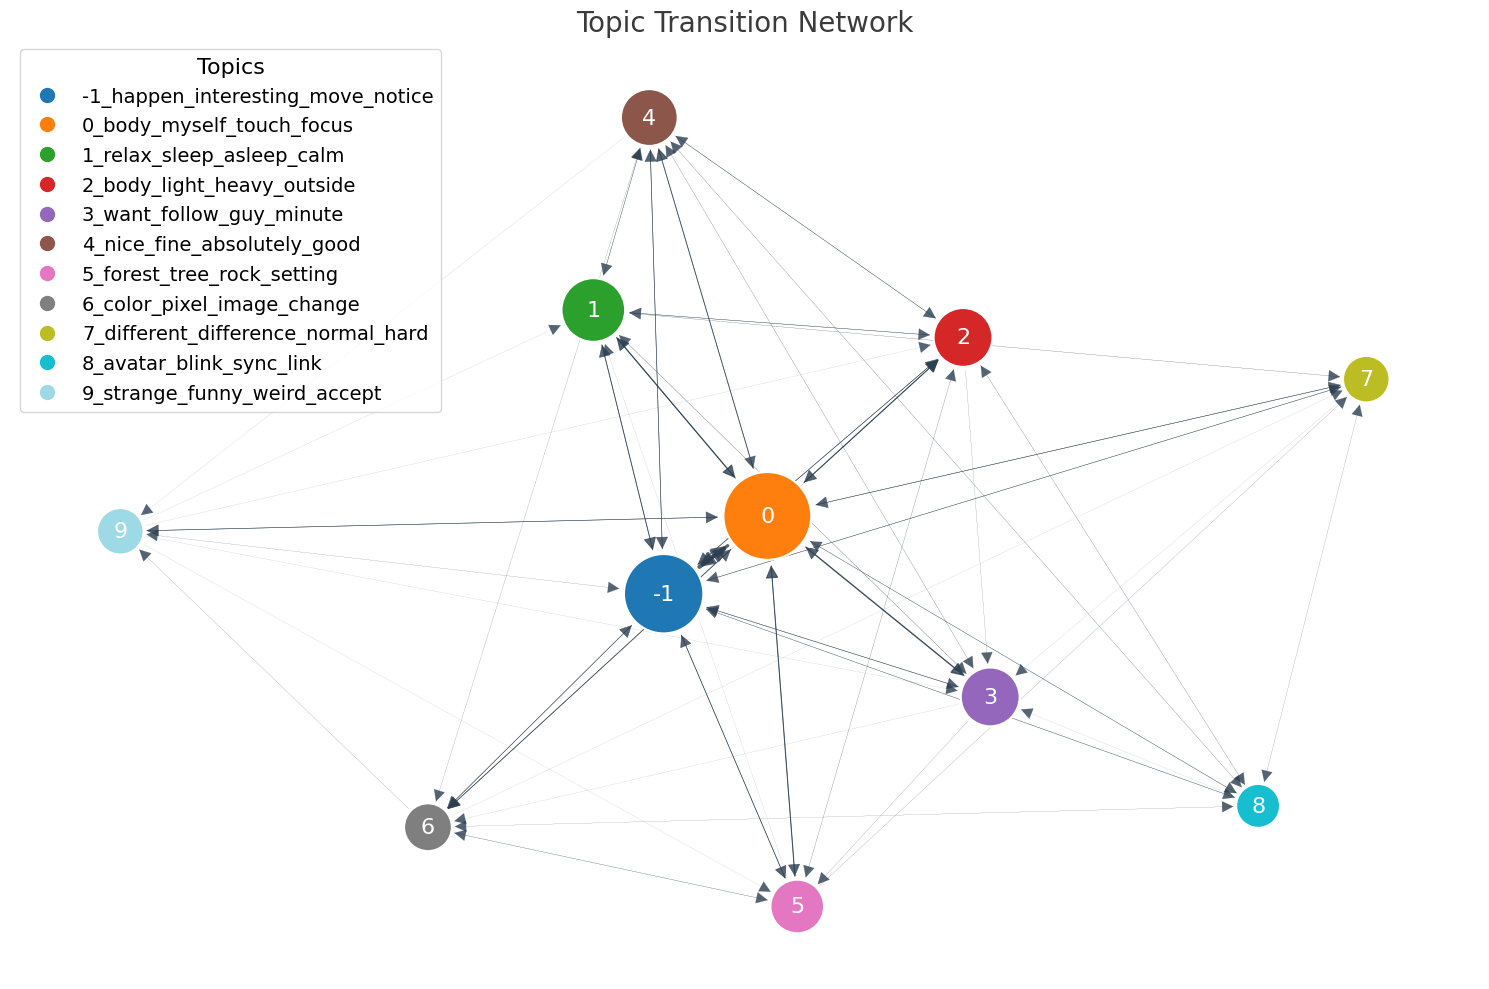

In [5]:
G = build_network_from_interviews(df, include_self_loops=False)
plot_topic_transition_network(G, show_edge_labels=False, palette=palette, size_by="appearance", file_name="images/topics_network.png") 
# size_by= appearance , occurrence, degree_centrality

**One single Interview**

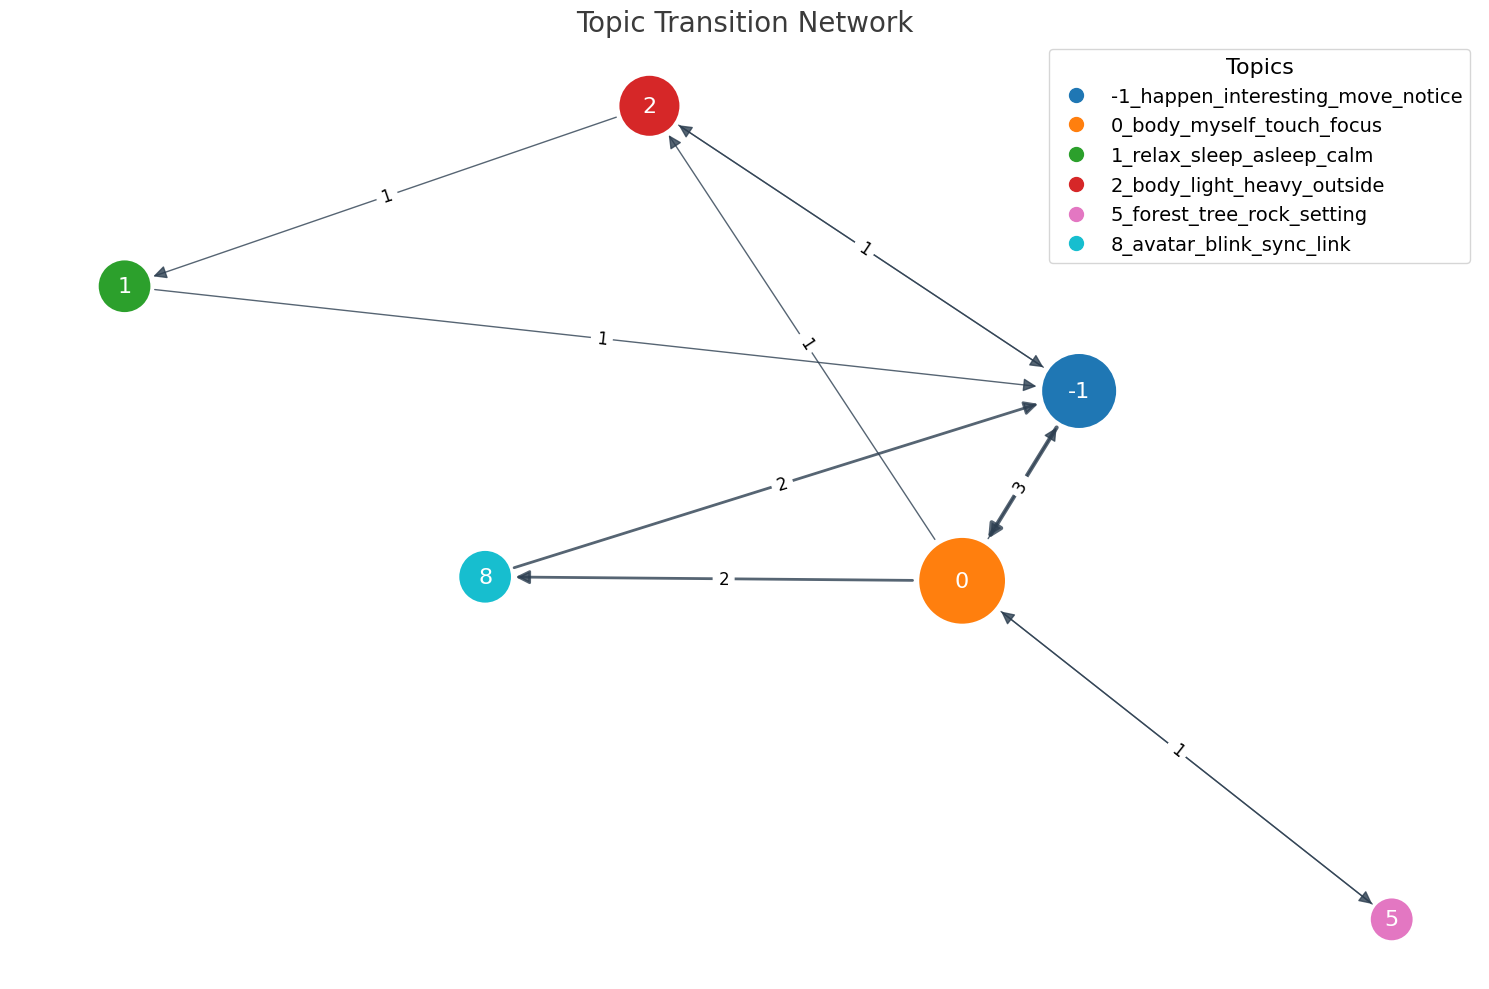

In [6]:
G_single = build_network_from_interviews(df[df["File Name"] == "S230 intervention"], include_self_loops=False)
plot_topic_transition_network(G_single, show_edge_labels=True,palette=palette, size_by="occurrence")

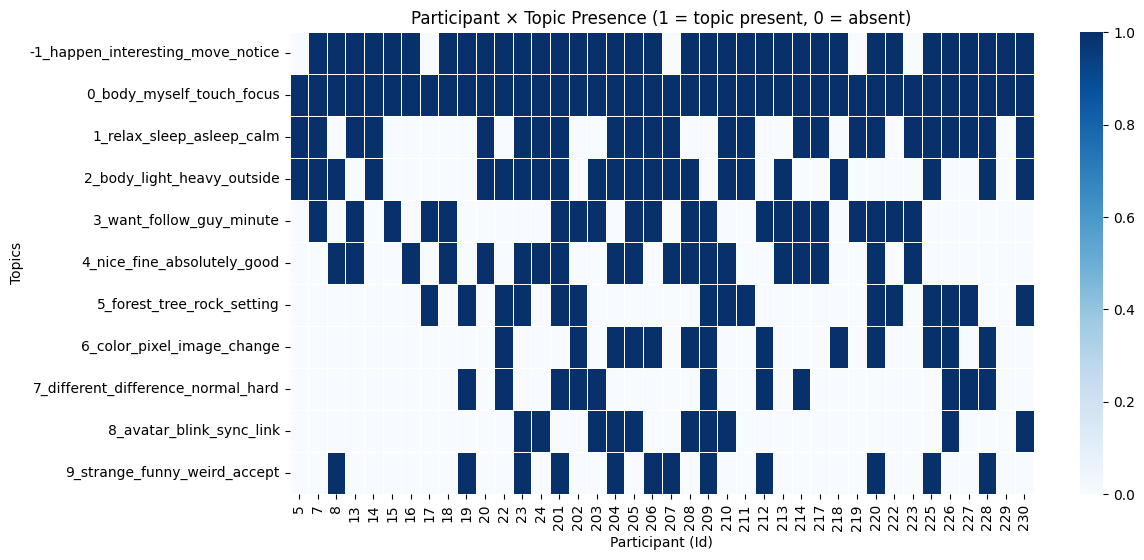

In [9]:
# 1. Count occurrences of each topic by participant
participant_topic_counts = (
    df.groupby(["Id", "one_topic_name"])["Content"]
    .size()
    .reset_index(name="Count")
)

# 2. Convert any Count > 0 to presence = 1
participant_topic_counts["Presence"] = (participant_topic_counts["Count"] > 0).astype(int)

# 3. Pivot to create a presence matrix
presence_matrix = participant_topic_counts.pivot(
    index="one_topic_name", 
    columns="Id", 
    values="Presence"
).fillna(0)

# 4. Visualize as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    presence_matrix, 
    cmap="Blues", 
    linewidths=.5,
)
plt.title("Participant × Topic Presence (1 = topic present, 0 = absent)")
plt.ylabel("Topics")
plt.xlabel("Participant (Id)")
plt.show()

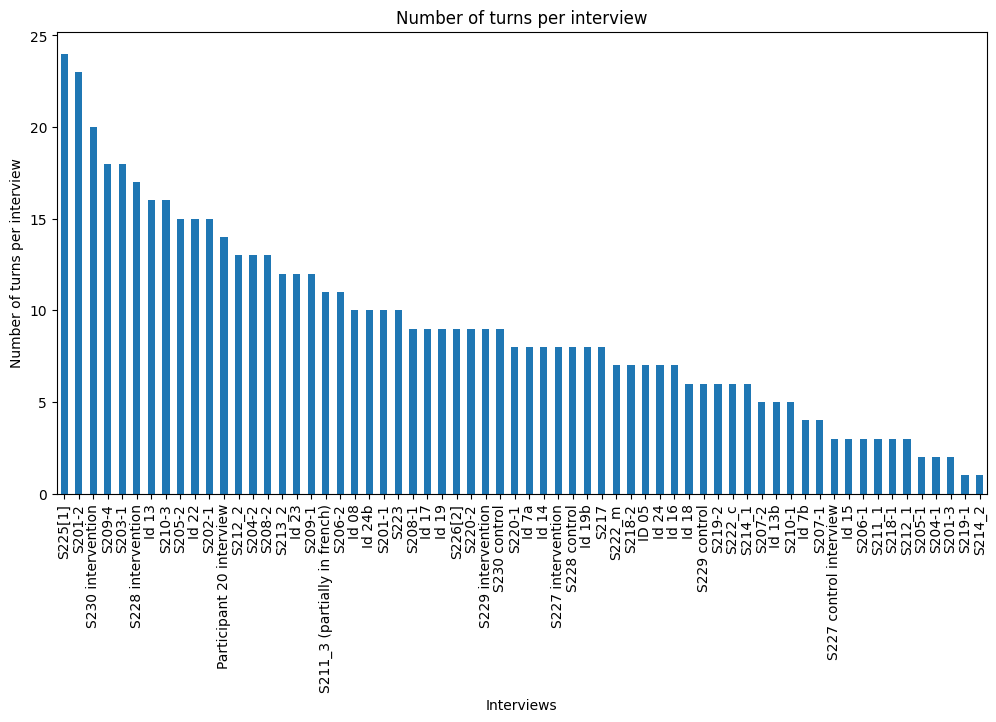

In [10]:
df["File Name"].value_counts().plot(kind="bar", figsize=(12, 6))
plt.ylabel("Number of turns per interview")
plt.xlabel("Interviews")
plt.title("Number of turns per interview")
plt.show()

# In-Depth (Multiple Topics/Turn) *Semi-Automatic* approach
We allow each turn to be labeled with multiple topics, which catches secondary or overlapping themes more accurately. However, it’s more complex to visualize and summarize, since a single turn can now connect to multiple topics.

This semi-automatic approach were instead of look at the overall distribution of topic, we can look to some specific topics that are interesting for the user.

In [11]:
def tag_topic(df, id_topic, exclude_indices, name_tag, multiple=False):
    single_topic_rows = df[df['one_topic'] == id_topic]
    multiple_topic_rows = df[df['multiple_topics'].map(lambda x: id_topic in x)]
    # Identify indices to tag from single topic or topics distribution
    rows_to_tag = single_topic_rows[~single_topic_rows.index.isin(exclude_indices)]
    if multiple:
        rows_to_tag = multiple_topic_rows[~multiple_topic_rows.index.isin(exclude_indices)]

    # Apply the tag
    df.loc[rows_to_tag.index, "tag"] = name_tag

def influence_analysis(topic_rows, tag_name):
    topic_rows = df[df['tag'] == tag_name]
    first_mentions = (
        topic_rows
        .sort_values(by='turn_index')
        .groupby('File Name', group_keys=False)
        .head(1)
        .reset_index(drop=True)
    )

    # Get participant IDs who mentioned the topic
    participant_rows = topic_rows[topic_rows['Speaker'] == 'Participant']
    participant_ids = participant_rows['Id'].unique()
    n_participants = len(participant_ids)

    # Find files where the Interviewer mentioned the topic first
    files_with_interviewer_first = first_mentions[first_mentions['Speaker'] == 'Interviewer']['File Name']

    # Count participants influenced by the Interviewer's first mention
    influenced_participants = participant_rows[
        participant_rows['File Name'].isin(files_with_interviewer_first)
    ]['Id'].unique()
    m_feedback = len(influenced_participants)

    # Print results
    print(f"Number of participants who mentioned the topic: {n_participants}")
    print(f"Participants who mentioned the topic: {list(participant_ids)}")

    print(f"Number of participants influenced by Interviewer mentioning the topic first: {m_feedback}")
    print(f"Participants influenced by Interviewer's first mention: {list(influenced_participants)}")

In [15]:
import ast

df = pd.read_csv("./outputs/topics/df_all_mix_tagged.csv")
# Re-convert 'multiple_topics' column strings to lists (lost during saving to csv)
df['multiple_topics'] = df['multiple_topics'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df.head(2)

,File Name,turn_index,Content,preprocessed_content,Experiment,Condition,Id,Speaker,Index,one_topic,one_topic_name,multiple_topics,multiple_topics_name,tag
0,ID 05,1,"So, that was very, let's say, unexpected and s...",let unexpected surprising moment realize disco...,OBE1,1,5,Participant,0,0,0_myself_body_reality_virtual,"[0, 34]","['0_myself_body_reality_virtual', '34_moment_j...",NaN
1,ID 05,3,"It was a little bit like, okay, well, so it's ...",watch outside special lot emotion explain moment,OBE1,1,5,Participant,1,0,0_myself_body_reality_virtual,"[0, 34]","['0_myself_body_reality_virtual', '34_moment_j...",NaN


In [16]:
df.one_topic_name.unique()

array(['0_myself_body_reality_virtual', '-1_look_hand_eye_head',
       '1_touch_delay_scene_image', '6_body_half_phrase_hard',
       '24_comfortable_sit_confortable_cushion',
       '2_eye_open_close_condition', '13_strange_funny_weird_accept',
       '23_quickly_happen_drop_dealaye', '31_heavy_light_weight_heavier',
       '28_absolutely_probable_definitely_positive',
       '5_platform_voice_rock_feedback', '12_easy_fun_free_nice',
       '25_fine_good_wow_ok', '34_moment_jar_instructive_affraid',
       '15_100_10_80_75', '7_want_follow_fell_resistance',
       '21_relief_relax_relaxed_release', '33_calm_peaceful_body_',
       '22_interesting_publish_knock_observe',
       '16_strange_scary_discomfort_fully',
       '14_connect_zoom_disconnect_link', '9_happy_long_day_mental',
       '4_forest_rock_river_indonesia', '32_float_reach_level_foot',
       '3_leg_focus_concentrate_distract',
       '27_expect_train_platform_scene', '11_fall_sleep_asleep_sleepy',
       '8_normal_diffe

## Tag
After manual observation of interesting topic.

In [44]:
df["tag"] = None

### Index to select for tagging

In [ ]:
list_index = [10,11,336,337,338,571,339,345,401]
df.loc[list_index, "tag"] = "heavy_light"

### Select all row from one topic minus some exclusion (after manual revision)

In [15]:
id_topic = 18
exclude_indices = [666]
tag_topic(df, id_topic, exclude_indices, "floating", multiple=False)

## Analyse the tagged data

In [17]:
df.tag.unique()

array([nan, 'heavy_light', 'floating', 'sleep', 'pixel_avatar'],
      dtype=object)

In [18]:
tag_name = "pixel_avatar"
influence_analysis(df, tag_name)

Number of participants who mentioned the topic: 8
Participants who mentioned the topic: [202, 204, 208, 209, 220, 226, 302, 306]
Number of participants influenced by Interviewer mentioning the topic first: 0
Participants influenced by Interviewer's first mention: []


In [23]:
#df.to_csv("./topics/df_tagged.csv", index=False)